In [ ]:
from nbdev import *
%nbdev_default_export source_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.source_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Source Data management
> Extract data for a source

### Overview

Given a point source, the class `SourceData` manages all data-oriented operations, providing all that is necessary to create a set of cells. It depends on the modules

* `config` 
    This must set up the paths to the data created by `data_man`, and define paths for the effective area and weight files

* effective_area
* weights

It implements `binned_exposure`

In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
import healpy
import pickle
from pathlib import Path

from wtlike.config import *
from wtlike.data_man import *
from wtlike.effective_area import *
from wtlike.weights import *

In [ ]:
%nbdev_hide
# check the weekly files
config = Config(wtlike_data='~/wtlike_data', verbose=2)
if config.valid:
    ff = get_data_files(config)
    source = PointSource('BL Lac') #Geminga')
    print(source)

Configuration parameters 
  verbose         : 2
  wtlike_data     : /home/burnett/wtlike_data
  cachepath       : /tmp/cache
  radius          : 4
  cos_theta_max   : 0.4
  z_max           : 100
  week_range      : (None, None)
  use_uint8       : False
  nside           : 1024
  nest            : True
  bins_per_decade : 4
  base_spectrum   : lambda E: (E/1000)**-2.1
  energy_range    : (100.0, 1000000.0)
  likelihood_rep  : poisson

Weekly folder "/home/burnett/wtlike_data/data_files" contains 664 weeks, from 9 to 673
Most recent data to UTC 2021-04-29 00:47
Source "BL Lac" at: (l,b)=(92.590,-10.441)


In [ ]:
%nbdev_export
def _exposure(config,  livetime, pcosine):
    """return exposure calculated for each pair in livetime and cosines arrays

    uses effective area
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effectivee area function from
    ea = EffectiveArea(file_path=config.wtlike_data/'aeff_files')

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def _calculate_exposure_for_source(config, source, week):
    """
    Calcualate the exposure for the source during the given week
    """
    df = week['sc_data']
    
    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame( 
        dict(
            start=df.start[mask], 
            stop=df.stop[mask], 
            exp=_exposure(config, livetime, pcosines[mask]),
            cos_theta=pcosines[mask],
        ))




### Check exposure with last data file

In [ ]:
%nbdev_hide
if config.valid:
    filename=ff[-1]
    week = pickle.load( open(filename,'rb') )
    e_df = _calculate_exposure_for_source(config, source, week); 
    print(e_df.head())

	Found 16,974 S/C entries:  6,463 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 4 bins/decade
       start      stop       exp  cos_theta
32  59326.04  59326.04  35659.36       0.42
33  59326.04  59326.05  39432.62       0.43
34  59326.05  59326.05  43399.47       0.45
35  59326.05  59326.05  47433.20       0.47
36  59326.05  59326.05  51586.01       0.49


In [ ]:
z = []
for f in ff:
    with open(f, 'rb') as inp:
        week = pickle.load(inp)
        wk = int(f.name[-7:-4])
        wk_start = week['tstart']/(7*24*3600)-386.44
        z.append(np.array([wk, wk_start]))

z=np.array(z)
z[0], z[-1]

(array([9.        , 9.65361276]), array([673.        , 672.99321925]))

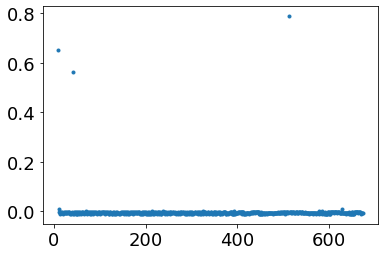

In [ ]:
plt.plot(z[:,0], z[:,1]-z[:,0], '.');

In [ ]:
%nbdev_export

def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - week : dict with 
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)
    
    if sum(incone)<2:
        print(f'\nWeek at {UTC(MJD(tstart))} has only {sum(incone)} photons')
        return
    
    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone]

    # distance from center for all accepted photons
    ll,bb = healpy.pix2ang(config.nside, dfc.nest_index,  nest=True, lonlat=True)
    cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
    t2 = np.degrees(np.array(np.sqrt((1.-np.dot(center, cart(ll,bb)))*2), np.float32))
    in_cone = t2<config.radius

    if config.verbose>2:
        print(f'\tGeometric cone cut: select {sum(in_cone)}')
    # assume all in the GTI (should check)

    # times: convert to float, add tstart, convert to MJD
    time = MJD(np.array(dfc.time, float)+tstart)

    # assemble the DataFrame, remove those outside the radius
    out_df = pd.DataFrame(np.rec.fromarrays(
        [np.array(dfc.band), time, dfc.nest_index, t2],
        names='band time pixel radius'.split()))[in_cone]

    # make sure times are monotonic by sorting (needed for most weeks after March 2018)
    out_df = out_df.sort_values(by='time')
    
    return out_df

### test photon data 

In [ ]:
%nbdev_hide
if config.valid:
    week = pickle.load(open(ff[0],'rb')); 
    tstart = week['tstart']
    print(f'TSTART: MET {tstart}, UTC {UTC(MJD(tstart))}')
    p_df = _get_photons_near_source(config, source, week )
    print(p_df.head())

TSTART: MET 239557417.0, UTC 2008-08-04 15:44
    band      time    pixel  radius
0      5  54682.69  5466843    2.13
5      6  54682.70  5457955    2.91
6      4  54682.77  5468769    3.20
7      0  54682.77  5466871    2.22
10     0  54682.77  5459333    3.50


In [ ]:
%nbdev_export      

def time_bin_edges(config, exposure, tbin=(0,0,1)):
    """Return an array of equally-spaced edges
    
    tbin: an array (a,b,d), default config.time_bins
    
    interpretation of a, b:

        if > 5000, interpret as MJD
        if <0, back from stop
        otherwise, offset from start
        
    
    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin

    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a


    if b>5000: stop=b
    elif b>0: stop = start+b
    else: stop += b


    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>1, 'Bad binning: no bins'
    stop = start+(nbins)*step
    return np.linspace(start,stop, nbins+1 )

In [ ]:
exposure = e_df
print(time_bin_edges(config, exposure))
print(time_bin_edges(config, exposure, (0,0,0.5)) )
print(time_bin_edges(config, exposure, (-5,0,2)) )
print(time_bin_edges(config, exposure, (0,1,0.25)) )
print(time_bin_edges(config, exposure, (-5,-4,0.25)) )   
print(time_bin_edges(config, exposure, (59326, 59330,0.5)) )    
 

[59326. 59327. 59328. 59329. 59330. 59331. 59332. 59333.]
[59326.  59326.5 59327.  59327.5 59328.  59328.5 59329.  59329.5 59330.
 59330.5 59331.  59331.5 59332.  59332.5 59333. ]
[59328. 59330. 59332.]
[59326.   59326.25 59326.5  59326.75 59327.  ]
[59328.   59328.25 59328.5  59328.75 59329.  ]
[59326.  59326.5 59327.  59327.5 59328.  59328.5 59329.  59329.5 59330. ]


In [ ]:
%nbdev_export

def _load_from_weekly_data(config, source):
    """
    Generate combinded DataFrames from a list of pickled files
    Either weekly or monthly
    """
    
    # check weights
    weight_file =  check_weights(config,  source)
    assert weight_file is not None
    
    data_folder = config.wtlike_data/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    iname = data_folder.name
    
    if config.verbose>0:
        print(f"Assembling photon data and exposure for source {source.name} from"\
              f' folder "{data_folder}", with {len(data_files)} files,'\
              f' last={data_files[-1].name}')
    if config.week_range is not None:
        if config.verbose>0:
            print(f'\tUsing weeks {config.week_range}')
        t = config.week_range
        data_files= data_files[t[0]:t[1]]
            

    verbose, config.verbose=config.verbose, 0
    # list of data framees
    pp = []
    ee = []
    for f in data_files:
        print('.', end='')
        with open(f, 'rb') as inp:
            week = pickle.load(inp)
        pp.append(_get_photons_near_source(config, source, week ))
        ee.append(_calculate_exposure_for_source(config, source, week ))
    print('');    
    config.verbose=verbose
    # concatenate the two lists of DataFrames
    p_df = pd.concat(pp, ignore_index=True)
    e_df = pd.concat(ee, ignore_index=True)

    if config.verbose>1:
        times = p_df.time.values
        print(f'Loaded {len(p_df):,} photons from {UTC(times[0])} to  {UTC(times[-1])} ')
        print(f'Calculated {len(e_df):,} exposure entries')
        
    # add weights to photon data
    add_weights(config, p_df, source)
        
    return p_df, e_df

class SourceData(object):
    """ Load the photon data near the source and associated exposure. 
    
    Either from:
      1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files with weekly or monthly data
      2. the cache, with key `{source.name}_data`
    
    * source_name : if specified, create a PointSource object
    * `config` : basic configuration
    * `source` : PointSource object if specified
    * `clear` : if set, overwrite the cached results
    """
    
    def __init__(self, source_name, config=None, source=None, clear=False):
        """ 

        """
            
        self.config = config if config else Config()
        if not (source_name or source):
            print('Must specify either the source name or a PointSource object', file=sys.stderr)
            return
 
        self.source = PointSource(source_name) if source_name else source
        self.source_name = self.source.name
        self.verbose = self.config.verbose
        
        key = f'{self.source.name}__data'
        self.source.data_key = key
        
        if self.config.wtlike_data/'data_files' is None and key not in config.cache:
            raise Exception(f'Data for {source.name} is not cached, and config.wtlike_data/"data_files" is not set')
        
        self.p_df, self.e_df = self.config.cache(key, 
                                    _load_from_weekly_data, self.config, self.source, 
                                    overwrite=clear,
                                    description=f'photons and exposure for {self.source.name}')
        if self.verbose>0:
            print(SourceData.__repr__(self))
    

    def __repr__(self):
        time = self.p_df.time.values
        r = f'{self.__class__.__name__}: Source {self.source.name} with:'\
            f'\n\t data:     {len(self.p_df):9,} photons from   {UTC(time[0])[:10]} to {UTC(time[-1])[:10]}'\
            f'\n\t exposure: {len(self.e_df):9,} intervals from {UTC(self.e_df.iloc[0].start)[:10]}'\
            f' to {UTC(self.e_df.iloc[-1].stop)[:10]}'
        return r
    
    def binned_exposure(self, time_bins):
        """Bin the exposure
        
        - time_bins: list of edges.  
        
        returns tuple with      
        - bexp: array of exposure integrated over each time bin, normalized to total
        - expbin average exposure/bin
      

        """
        config = self.config

        # get exposure calculation
        exp   = self.e_df.exp.values
        estart= self.e_df.start.values
        estop = self.e_df.stop.values

        # determine bins,

        #use cumulative exposure to integrate over larger periods
        cumexp = np.concatenate(([0],np.cumsum(exp)) )

        # get index into tstop array of the bin edges
        edge_index = np.searchsorted(estop, time_bins)
        # return the exposure integrated over the intervals
        cum = cumexp[edge_index]
        expbin = (cum[-1]-cum[0])/(len(time_bins)-1) 
        bexp = np.diff(cum) / expbin 
        if config.verbose>1:
            print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
        return bexp, expbin
    
    def binned_cos_theta(self, time_bins=None):
        """ Calculate average cosine of angle with respect to bore axis, per time bin
        """
        if time_bins is None:
            time_bins = get_default_bins(self.config, self.e_df)
        df = self.e_df.copy()
        estop =df.stop.values
        df.loc[:,'tbin'] =np.digitize(estop, time_bins)
        ct = df.groupby('tbin').mean()['cos_theta']
        return ct, time_bins
    
    def weight_histogram(self, nbins=1000, key=''):
        """ return a weight distribution
        """
        def doit(nbins):
            return np.histogram(self.p_df.weight.values, np.linspace(0,1,nbins+1))[0]

        key = f'{self.source.name}_weight_hist' if key=='' else key
        description = f'Weight histogram for {self.source.name}' if self.config.verbose>0 else ''
        return self.config.cache(key, doit, nbins, description=description)
        
    def plot_data(self):
        import matplotlib.pyplot as plt
        fig, (ax1,ax2, ax3,ax4) = plt.subplots(1,4, figsize=(15,4))
        ax1.hist(self.p_df.time.values, 500, histtype='step');
        ax1.set(xlabel='Time (MJD)')
        ax2.hist(self.p_df.radius.values, 500, histtype='step');
        ax2.set(xlabel='Radius (deg)');
        
        ax3.hist(self.p_df.band, 32, histtype='step', log=True);
        ax3.set(xlabel='Band index')
        ax4.hist(self.p_df.weight, 100, histtype='step')
        ax4.set(xlabel='weight');

In [ ]:
#hide
show_doc(SourceData)
show_doc(SourceData.binned_exposure)

<h2 id="SourceData" class="doc_header"><code>class</code> <code>SourceData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SourceData</code>(**`source_name`**, **`config`**=*`None`*, **`source`**=*`None`*, **`clear`**=*`False`*)

Load the photon data near the source and associated exposure. 

Either from:
  1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files with weekly or monthly data
  2. the cache, with key `{source.name}_data`

* source_name : if specified, create a PointSource object
* [`config`](/wtlikeconfig) : basic configuration
* `source` : PointSource object if specified
* `clear` : if set, overwrite the cached results

<h4 id="SourceData.binned_exposure" class="doc_header"><code>SourceData.binned_exposure</code><a href="__main__.py#L103" class="source_link" style="float:right">[source]</a></h4>

> <code>SourceData.binned_exposure</code>(**`time_bins`**)

Bin the exposure

- time_bins: list of edges.  

returns tuple with      
- bexp: array of exposure integrated over each time bin, normalized to total
- expbin average exposure/bin

## Test a single week

In [ ]:
# config2 = Config(data_folder='/home/burnett/weekly', week_range=(-1,None), time_interval=15/(24*60), verbose=2)
# sd2 = SourceData(config2, source, clear=True); 
# sd2.plot()

## Test extracting full dataset

photons and exposure for Geminga: Restoring from cache with key "Geminga__data"
SourceData: Source Geminga with:
	 data:     1,412,008 photons from   2008-08-04 to 2021-04-28
	 exposure: 3,112,161 intervals from 2008-08-04 to 2021-04-28


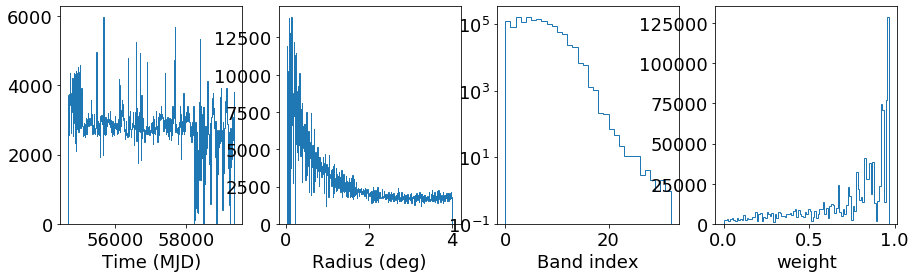

In [ ]:
%nbdev_hide
sd = SourceData('Geminga') 
sd.plot_data()

Development of code to summarize cos theta

In [ ]:
%nbdev_hide
# sd.e_df.cos_theta.hist(bins=100);

# plt.plot(sd.weight_histogram(200,key=None), '.')

# self = sd
# time_bins = None
# if time_bins is None:
#     time_bins = get_default_bins(config, self.e_df)

# df = self.e_df.copy()
# estop =df.stop.values
# df.loc[:,'tbin'] = np.digitize(estop, time_bins)
# ct = df.groupby('tbin').mean()['cos_theta']
# ct, bins = sd.binned_cos_theta()
# print(len(ct), len(time_bins))
# print(ct)

# ctx = df.groupby('tbin').agg({'cos_theta': ['count','mean', 'min', 'max']})
# print(ctx)

# ct, bins = sd.binned_cos_theta()
# print(len(ct), len(bins))
# plt.plot(ct.index[:100], ct[:100],'.');

In [ ]:
%nbdev_hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_data_man.ipynb.
Converted 03_source_data.ipynb.
Converted 03_weights.ipynb.
Converted 04_photon_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Mon May  3 15:33:47 PDT 2021
